In [1]:
import numpy as np 
import xarray as xr
import pandas as pd 
import os.path
import matplotlib.pyplot as plt 

Text(0, 0.5, 'BCC')

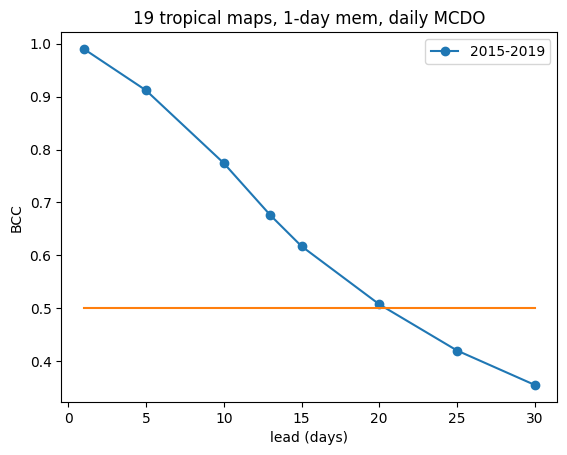

In [4]:
# combine the prediction in 2015-2019
nmem = 1  # use 30 time steps in each input map

dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_36yrtraining_RMMERA5_filtered_trop/old/'
# dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop_os_yr_dpr/output/'

varnum = 19

# if nmem == 30:
#     dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/7maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output_dp0203_30mem/'
# elif nmem == 1:
#     dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/7maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output_dp0102_ep50_1mem/'

lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead
# lead = [1, 5, 10, 13, 20, 25] 
BCC  = []
RMSE = []
err  = []

for ilead, leadmjo in zip(np.arange(len(lead)), lead): 
    ds = []
    # combine 2015-2019 prediction for the lead
    dsp = []
    dst = []
    dspstd = []

    for yn in np.arange(2015,2020):
        fnp=dirn + 'predicted_MCDO_UNET_'+str(varnum)+'mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
        fnt=dirn + 'truth_MCDO_UNET_'+str(varnum)+'mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'

        # fnp = dirn + 'predicted_MCDO_UNET_'+str(varnum)+'mapstrop_RMMERA5_1979to2020_lead' + str(leadmjo) + '_dpr0.40.3_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
        # fnt = dirn + 'truth_MCDO_UNET_'+str(varnum)+'mapstrop_RMMERA5_1979to2020_lead' + str(leadmjo) + '_dpr0.40.3_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'

        # fnpstd=dirn + 'predicted_disstd_MCDO_UNET_'+str(varnum)+'mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'

        df = pd.read_csv(fnp,index_col=None, header=None, names=['RMMp1','RMMp2'])
        dsp.append(df)
        del df 
        df = pd.read_csv(fnt,index_col=None, header=None, names=['RMMt1','RMMt2'])
        dst.append(df)
        del df 
        # df = pd.read_csv(fnpstd,index_col=None, header=None, names=['std1','std2'])
        # dspstd.append(df)
        # del df 

    dsp0 = pd.concat(dsp, axis=0, ignore_index=True)
    dst0 = pd.concat(dst, axis=0, ignore_index=True)
    # dspstd0 = pd.concat(dspstd, axis=0, ignore_index=True)

    # ds0 = pd.concat((dsp0,dst0,dspstd0), axis=1)
    ds0 = pd.concat((dsp0,dst0), axis=1)

    ds.append(ds0.copy())
    del ds0
        
    iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
    # iniRMM = xr.open_dataset('/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/RMM_ERA5_daily_1901to2020.nc')

    if nmem == 1:
        a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
        b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))
    elif nmem == 30:
        a = iniRMM.sel(time=slice('2015-01-30','2017-01-28'))
        b = iniRMM.sel(time=slice('2017-01-30','2020-01-29'))

    iniRMM = xr.concat((a,b), dim='time')
    del a 
    del b 
    RMM1 = iniRMM['RMM'][:,0]
    RMM2 = iniRMM['RMM'][:,1]
    IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)
    ds[0]['IniAmp'] = IniAmp.values 

    # std1 = ds[0]['std1']
    # std2 = ds[0]['std2']
    # std = np.sqrt(std1*std1+std2*std2)
    # ds[0]['std'] = std.values

    # finish combination
    # evaluation starts 
    ds = ds[0]
    ds = ds.loc[ds['IniAmp']>=1]

    r1p = np.asarray(ds['RMMp1'])
    r2p = np.asarray(ds['RMMp2'])
    r1t = np.asarray(ds['RMMt1'])
    r2t = np.asarray(ds['RMMt2'])
    # std = np.asarray(ds['std'])

    A = np.sum(r1p * r1t + r2p * r2t)
    B = np.sqrt(np.sum(r1p * r1p + r2p * r2p))
    C = np.sqrt(np.sum(r1t * r1t + r2t * r2t))
    BCC.append(A / B / C)

    d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
    RMSE.append(np.sqrt(d))  # RMSE at each time step
    # err.append(std)
    del ds 


import matplotlib.pyplot as plt 

plt.plot(lead, BCC, 'o-', label='2015-2019')
plt.plot(lead, 0.5 * np.ones(len(lead)))
plt.legend()
plt.title(str(varnum)+' tropical maps, '+str(nmem)+'-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('BCC')

In [27]:
def get_BCC_RMSE_debug(fnRMM, lead, testyrsta, testyrend, dnp, dnt, nmem):
    # analyze error source
    RMSE = []
    err  = []
    # ds = []
    # pha_err = []
    BCC = []

    dsrmm = xr.open_dataset(fnRMM)

    for ilead, leadmjo in zip(np.arange(len(lead)), lead): 
        # combine 2015-2019 prediction for the lead
        dsp = []
        dst = []
        # dspstd = []

        for yn in np.arange(testyrsta,testyrend):
            datesta = np.datetime64(str(yn))
            dateend = datesta + np.timedelta64(365, 'D')
            time_ind = np.arange(datesta, dateend)

            fnp= dnp + 'predicted_MCDO_UNET_19mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
            fnt= dnt + 'truth_MCDO_UNET_19mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
            # fnpstd=dirn + 'predicted_disstd_MCDO_UNET_'+str(varnum)+'maps'+flg+'_RMMERA5_'+str(yrlen)+'yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'

            # read RMM1 and RMM2 at the initial time steps
            inirmm = dsrmm['RMM'].sel(time=slice(datesta, datesta + np.timedelta64(364, 'D')))

            df = pd.read_csv(fnp,index_col=None, header=None, names=['RMMp1','RMMp2'])
            df['RMMi1'] = inirmm[:,0].values
            df['RMMi2'] = inirmm[:,1].values
            df['IniTime'] = time_ind
            df.set_index('IniTime')
            dsp.append(df)
            del df 

            df = pd.read_csv(fnt,index_col=None, header=None, names=['RMMt1','RMMt2'])
            df['IniTime'] = time_ind
            df.set_index('IniTime')
            dst.append(df)
            del df 
            

        dsp0 = pd.concat(dsp, axis=0) # , ignore_index=True)
        dst0 = pd.concat(dst, axis=0) # , ignore_index=True)
        # dspstd0 = pd.concat(dspstd, axis=0, ignore_index=True)

        ds0 = pd.concat((dsp0,dst0), axis=1)

        ds = ds0.copy()
        del ds0
            

        RMM1 = ds['RMMi1']
        RMM2 = ds['RMMi2']
        IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)
        ds['IniAmp'] = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)

        # ds[ilead]['month'] = pd.DatetimeIndex(ds[ilead].IniTime).month
        # ds[ilead]['Phase'] = Phase

        # std1 = ds[ilead]['std1']
        # std2 = ds[ilead]['std2']
        # std = np.sqrt(std1*std1+std2*std2)
        # ds[ilead]['std'] = std.values

        # finish combination
        # evaluation starts 
        ds0 = ds.copy()
        dstmp = ds0.loc[ds0['IniAmp']>=1]
        del ds 

        ds = dstmp.copy()
        del ds0 
        del dstmp

        r1p = np.asarray(ds['RMMp1'])
        r2p = np.asarray(ds['RMMp2'])
        r1t = np.asarray(ds['RMMt1'])
        r2t = np.asarray(ds['RMMt2'])
        # std = np.asarray(ds[ilead]['std'])

        # BCC
        a = sum(r1p*r1t+r2p*r2t)
        b = np.sqrt(sum(r1t*r1t+r2t*r2t))
        c = np.sqrt(sum(r1p*r1p+r2p*r2p))
        BCC.append(a/b/c) 

        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
        ds['RMSE'] = np.sqrt(d)
        RMSE.append(np.sqrt(d))  # RMSE at each time step
        # err.append(std)

        # a = r1t * r2p - r2t * r1p 
        # b = r1t * r1p + r2t * r2p
        # c = a / b 
        # d = np.arctan(c) * 180. / np.pi
        # ds[ilead]['pha_err'] = d
        # pha_err.append(d)

        # del ds 

    avRMSE = np.mean(RMSE,axis=1)

    return BCC, avRMSE, ds 



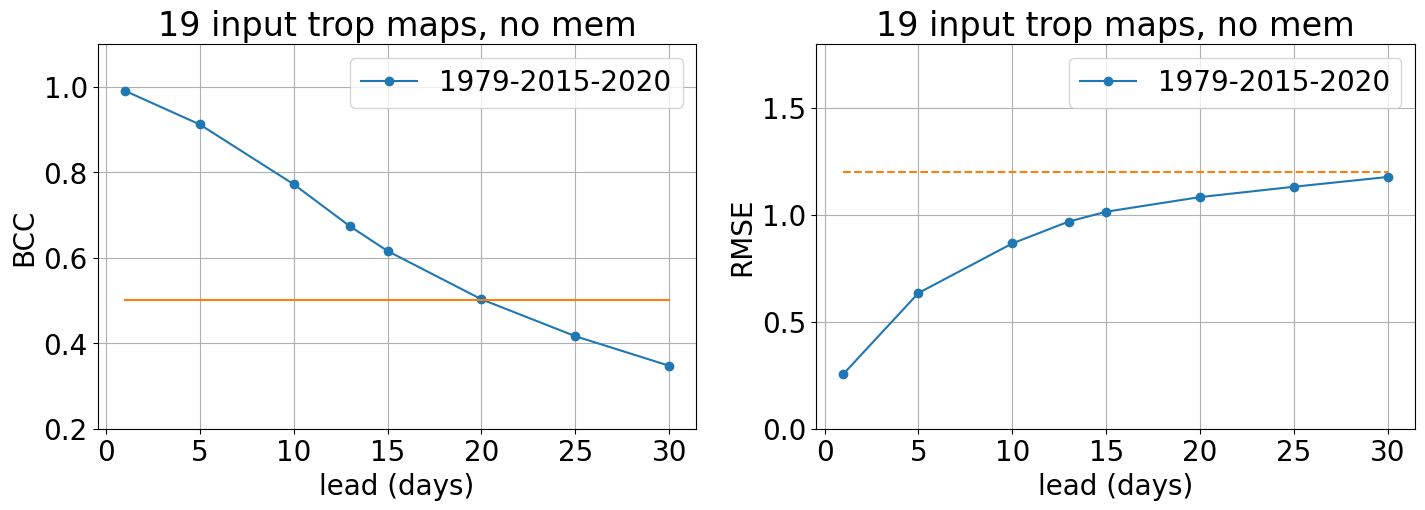

In [28]:
RMSE_exp = []
BCC_exp = []

nmem = 1
varnum = 19  # number of input maps
# yrlen = []  # how many years in the training dataset. 94 is actually 114. 
flg = 'trop'  # 'trop' means [-20, 20], '60deg' means [-60, 60]
fnRMM = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/RMM_ERA5_daily_1901to2020.nc'  # file path for the obs RMM

# transfer 1959-2020, 1901-2020, 1901-1958, 1959-2020, 1999-2020
yrsta = [1959, 1901, 1901, 1959, 1979, 1999]  # starting year in training
yrvld = [2015, 2015, 1953, 2015, 2015, 2015]  # starting year in testing 
yrend = [2020, 2020, 1958, 2020, 2020, 2020]  # ending year in testing not included but used.

dirp = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output/'

dirt = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output/'

lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead

exp = 4 

testyrsta = yrvld[exp]
testyrend = yrend[exp]

dnp = dirp
dnt = dirt
a, b, ds = get_BCC_RMSE_debug(fnRMM, lead, testyrsta, testyrend, dnp, dnt, nmem)
BCC_exp.append(a)
RMSE_exp.append(b)

import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(17,5))
gs = fig.add_gridspec(1, 2, hspace=0.05, wspace=0.2)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})


testyrsta = yrvld[exp]
testyrend = yrend[exp]

ax[0].plot(lead, BCC_exp[0], 'o-', label=str(yrsta[exp])+'-'+str(testyrsta)+'-'+str(testyrend))
ax[0].plot(lead, 0.5 * np.ones(len(lead)))
ax[0].legend()

ax[1].plot(lead, RMSE_exp[0], 'o-', label=str(yrsta[exp])+'-'+str(testyrsta)+'-'+str(testyrend))
ax[1].legend()
ax[1].plot(lead,1.2*np.ones(len(lead)),'--')

ax[1].set_title(str(varnum)+' input '+flg+' maps, no mem')
ax[1].set_xlabel('lead (days)')
ax[1].set_ylabel('RMSE')
ax[1].set_ylim([0,1.8])
ax[1].grid(visible=True)
ax[0].set_title(str(varnum)+' input '+flg+' maps, no mem')
ax[0].set_xlabel('lead (days)')
ax[0].set_ylabel('BCC')
ax[0].set_ylim([0.2,1.1])
ax[0].grid(visible=True)

In [26]:
ds 

,RMMp1,RMMp2,RMMi1,RMMi2,IniTime,RMMt1,RMMt2,IniTime,IniAmp,RMSE
0,-0.497662,0.519652,-1.388955,0.579924,2015-01-01,0.436808,0.809733,2015-01-01,1.505161,0.978459
1,-0.759318,0.198152,-1.225615,0.400374,2015-01-02,0.310482,0.714495,2015-01-02,1.289353,1.187889
2,-0.700300,0.302468,-1.275347,-0.027117,2015-01-03,0.367825,1.008025,2015-01-03,1.275635,1.280118
3,-0.440692,0.389875,-1.494040,-0.303494,2015-01-04,0.417131,1.284530,2015-01-04,1.524554,1.239462
4,-0.907774,0.498563,-1.861554,-0.596937,2015-01-05,0.266450,0.995634,2015-01-05,1.954921,1.275100
...,...,...,...,...,...,...,...,...,...,...
360,0.443647,0.106848,-1.304739,-1.569185,2015-12-27,0.223314,-0.011257,2015-12-27,2.040756,0.249991
361,0.365331,-0.023440,-1.038541,-1.958746,2015-12-28,0.569932,-0.039894,2015-12-28,2.217037,0.205261
362,0.033300,0.160042,-0.803611,-2.026915,2015-12-29,0.870995,-0.028335,2015-12-29,2.180407,0.858615
363,-0.028609,0.559846,-0.553757,-2.081882,2015-12-30,0.979616,0.176804,2015-12-30,2.154271,1.078535


In [31]:
def get_BCC_RMSE(fnRMM, lead, testyrsta, testyrend, dnp, dnt, nmem):
    # analyze error source
    RMSE = []
    err  = []
    ds = []
    # pha_err = []
    BCC = []

    dsrmm = xr.open_dataset(fnRMM)

    for ilead, leadmjo in zip(np.arange(len(lead)), lead): 
        # ds = []
        # combine 2015-2019 prediction for the lead
        dsp = []
        dst = []
        # dspstd = []

        for yn in np.arange(testyrsta,testyrend):
            datesta = np.datetime64(str(yn))
            dateend = datesta + np.timedelta64(365, 'D')
            time_ind = np.arange(datesta, dateend)

            fnp= dnp + 'lead' + str(leadmjo) + '_dpr0.40.3_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
            fnt= dnt + 'lead' + str(leadmjo) + '_dpr0.40.3_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
            # fnpstd=dirn + 'predicted_disstd_MCDO_UNET_'+str(varnum)+'maps'+flg+'_RMMERA5_'+str(yrlen)+'yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'

            # read RMM1 and RMM2 at the initial time steps
            inirmm = dsrmm['RMM'].sel(time=slice(datesta, datesta + np.timedelta64(364, 'D')))

            df = pd.read_csv(fnp,index_col=None, header=None, names=['RMMp1','RMMp2'])
            df['RMMi1'] = inirmm[:,0].values
            df['RMMi2'] = inirmm[:,1].values
            df['IniTime'] = time_ind
            df.set_index('IniTime')
            dsp.append(df)
            del df 

            df = pd.read_csv(fnt,index_col=None, header=None, names=['RMMt1','RMMt2'])
            df['IniTime'] = time_ind
            df.set_index('IniTime')
            dst.append(df)
            del df 
            

        dsp0 = pd.concat(dsp, axis=0) # , ignore_index=True)
        dst0 = pd.concat(dst, axis=0) # , ignore_index=True)
        # dspstd0 = pd.concat(dspstd, axis=0, ignore_index=True)

        ds0 = pd.concat((dsp0,dst0), axis=1)

        ds.append(ds0.copy())
        del ds0
            

        RMM1 = ds[ilead]['RMMi1']
        RMM2 = ds[ilead]['RMMi2']
        IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)
        ds[ilead]['IniAmp'] = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)

        # ds[ilead]['month'] = pd.DatetimeIndex(ds[ilead].IniTime).month
        # ds[ilead]['Phase'] = Phase

        # std1 = ds[ilead]['std1']
        # std2 = ds[ilead]['std2']
        # std = np.sqrt(std1*std1+std2*std2)
        # ds[ilead]['std'] = std.values

        # finish combination
        # evaluation starts 
        ds0 = ds[ilead].copy()
        dstmp = ds0.loc[ds0['IniAmp']>=1]
        ds[ilead] = dstmp.copy()
        del ds0 
        del dstmp

        r1p = np.asarray(ds[ilead]['RMMp1'])
        r2p = np.asarray(ds[ilead]['RMMp2'])
        r1t = np.asarray(ds[ilead]['RMMt1'])
        r2t = np.asarray(ds[ilead]['RMMt2'])
        # std = np.asarray(ds[ilead]['std'])

        # BCC
        a = sum(r1p*r1t+r2p*r2t)
        b = np.sqrt(sum(r1t*r1t+r2t*r2t))
        c = np.sqrt(sum(r1p*r1p+r2p*r2p))
        BCC.append(a/b/c) 

        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
        ds[ilead]['RMSE'] = np.sqrt(d)
        RMSE.append(np.sqrt(d))  # RMSE at each time step
        # err.append(std)

        # a = r1t * r2p - r2t * r1p 
        # b = r1t * r1p + r2t * r2p
        # c = a / b 
        # d = np.arctan(c) * 180. / np.pi
        # ds[ilead]['pha_err'] = d
        # pha_err.append(d)

    avRMSE = np.mean(RMSE,axis=1)

    return BCC, avRMSE

In [34]:
RMSE_exp = []
BCC_exp = []

nmem = 1
varnum = 19  # number of input maps
# yrlen = []  # how many years in the training dataset. 94 is actually 114. 
flg = 'trop'  # 'trop' means [-20, 20], '60deg' means [-60, 60]
fnRMM = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/RMM_ERA5_daily_1901to2020.nc'  # file path for the obs RMM

# transfer 1959-2020, 1901-2020, 1901-1958, 1959-2020, 1999-2020
yrsta = [1959, 1901, 1901, 1959,  1999]  # starting year in training
yrvld = [2015, 2015, 1953, 2015,  2015]  # starting year in testing 
yrend = [2020, 2020, 1958, 2020,  2020]  # ending year in testing not included but used.

dirp = [
    '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop_transfer_os_yr_dpr/output/predicted_MCDO_UNET_19mapstrop_RMMERA5_1959to2020_',
    '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop_os_yr_dpr/output/predicted_MCDO_UNET_19mapstrop_RMMERA5_1901to2020_',
    '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop_os_yr_dpr/output/predicted_MCDO_UNET_19mapstrop_RMMERA5_1901to1958_',
    '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop_os_yr_dpr/output/predicted_MCDO_UNET_19mapstrop_RMMERA5_1959to2020_',
    '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop_os_yr_dpr/output/predicted_MCDO_UNET_19mapstrop_RMMERA5_1999to2020_',
]

dirt = [
    '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop_transfer_os_yr_dpr/output/truth_MCDO_UNET_19mapstrop_RMMERA5_1959to2020_',
    '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop_os_yr_dpr/output/truth_MCDO_UNET_19mapstrop_RMMERA5_1901to2020_',
    '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop_os_yr_dpr/output/truth_MCDO_UNET_19mapstrop_RMMERA5_1901to1958_',
    '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop_os_yr_dpr/output/truth_MCDO_UNET_19mapstrop_RMMERA5_1959to2020_',
    '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop_os_yr_dpr/output/truth_MCDO_UNET_19mapstrop_RMMERA5_1999to2020_',
]

lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead

# set parameters for each run
for exp in [0,1,2,3,4]:
        testyrsta = yrvld[exp]
        testyrend = yrend[exp]

        dnp = dirp[exp]
        dnt = dirt[exp]
        a, b = get_BCC_RMSE(fnRMM, lead, testyrsta, testyrend, dnp, dnt, nmem)
        BCC_exp.append(a)
        RMSE_exp.append(b)

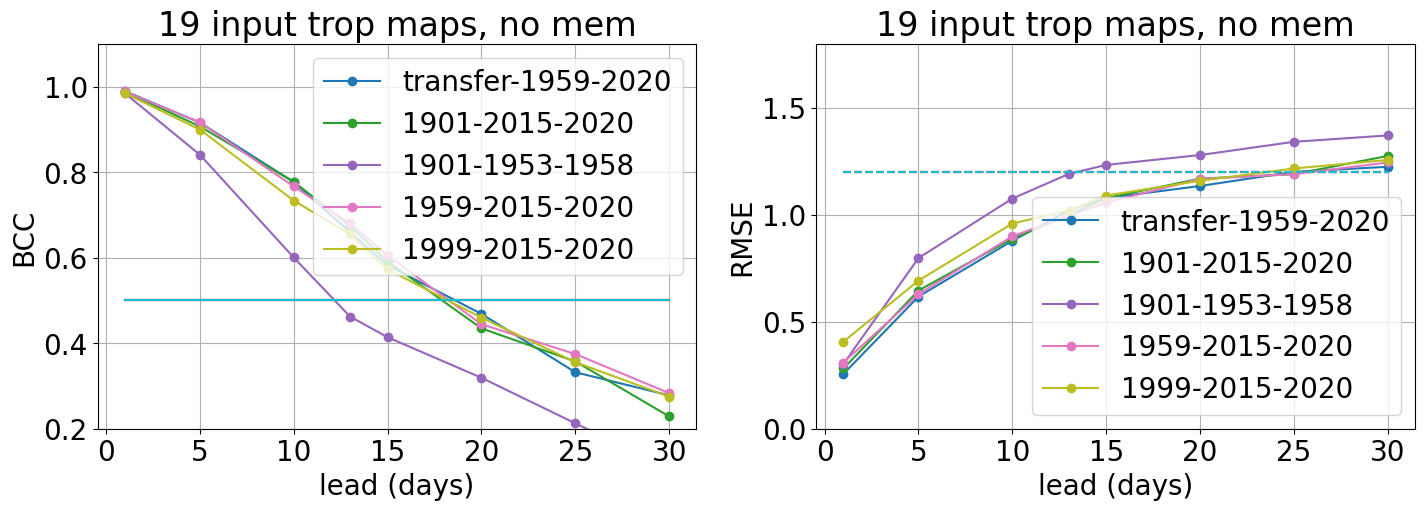

In [35]:
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(17,5))
gs = fig.add_gridspec(1, 2, hspace=0.05, wspace=0.2)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

exp = 0 
testyrsta = yrvld[exp]
testyrend = yrend[exp]
ax[0].plot(lead, BCC_exp[exp], 'o-', label='transfer-'+str(yrsta[exp])+'-'+str(testyrend))
ax[0].plot(lead, 0.5 * np.ones(len(lead)))
ax[0].legend()

ax[1].plot(lead, RMSE_exp[exp], 'o-', label='transfer-'+str(yrsta[exp])+'-'+str(testyrend))
ax[1].legend()
ax[1].plot(lead,1.2*np.ones(len(lead)),'--')

for exp in [1,2,3,4]:
    testyrsta = yrvld[exp]
    testyrend = yrend[exp]
    ax[0].plot(lead, BCC_exp[exp], 'o-', label=str(yrsta[exp])+'-'+str(testyrsta)+'-'+str(testyrend))
    ax[0].plot(lead, 0.5 * np.ones(len(lead)))
    ax[0].legend()

    ax[1].plot(lead, RMSE_exp[exp], 'o-', label=str(yrsta[exp])+'-'+str(testyrsta)+'-'+str(testyrend))
    ax[1].legend()
    ax[1].plot(lead,1.2*np.ones(len(lead)),'--')

ax[1].set_title(str(varnum)+' input '+flg+' maps, no mem')
ax[1].set_xlabel('lead (days)')
ax[1].set_ylabel('RMSE')
ax[1].set_ylim([0,1.8])
ax[1].grid(visible=True)
ax[0].set_title(str(varnum)+' input '+flg+' maps, no mem')
ax[0].set_xlabel('lead (days)')
ax[0].set_ylabel('BCC')
ax[0].set_ylim([0.2,1.1])
ax[0].grid(visible=True)

In [51]:
RMSE_exp = []
BCC_exp = []

nmem = 1  # memory time steps
yrsta = [1901, 1901, 1959, 1979]  # starting year in training
yrvld = [1953, 2015, 2015, 2015]
yrend = [1958, 2020, 2020, 2020]  # ending year in testing 
varnum = 19  # number of input maps
# yrlen = []  # how many years in the training dataset. 94 is actually 114. 
flg = 'trop'  # 'trop' means [-20, 20], '60deg' means [-60, 60]

fnRMM = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/RMM_ERA5_daily_1901to2020_base1979.nc'  # file path for the obs RMM
# transfer 1959-2020, 1901-2020, 
dirp = ['/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop_transfer_os_yr_dpr/output/predicted_MCDO_UNET_19mapstrop_RMMERA5_1901to1958_',
        '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop/output/predicted_MCDO_UNET_19mapstrop_RMMERA5_1901to1958_',
        '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop1/output/predicted_MCDO_UNET_19mapstrop_RMMERA5_1901to2020_',
        '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop2/output/predicted_MCDO_UNET_19mapstrop_RMMERA5_1959to2020_',
        '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output/predicted_MCDO_UNET_19mapstrop_RMMERA5_36yr_',
]

dirt = ['/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop/output/truth_MCDO_UNET_19mapstrop_RMMERA5_1901to1958_',
        '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop1/output/truth_MCDO_UNET_19mapstrop_RMMERA5_1901to2020_',
        '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_RMMERA5_filtered_trop2/output/truth_MCDO_UNET_19mapstrop_RMMERA5_1959to2020_',
        '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output/truth_MCDO_UNET_19mapstrop_RMMERA5_36yr_',
]

lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead

# set parameters for each run
for exp in range(len(yrsta)):
        testyrsta = yrvld[exp]
        testyrend = yrend[exp]

        dnp = dirp[exp]
        dnt = dirt[exp]
        a, b = get_BCC_RMSE(fnRMM, lead, testyrsta, testyrend, dnp, dnt, nmem)
        BCC_exp.append(a)
        RMSE_exp.append(b)
        


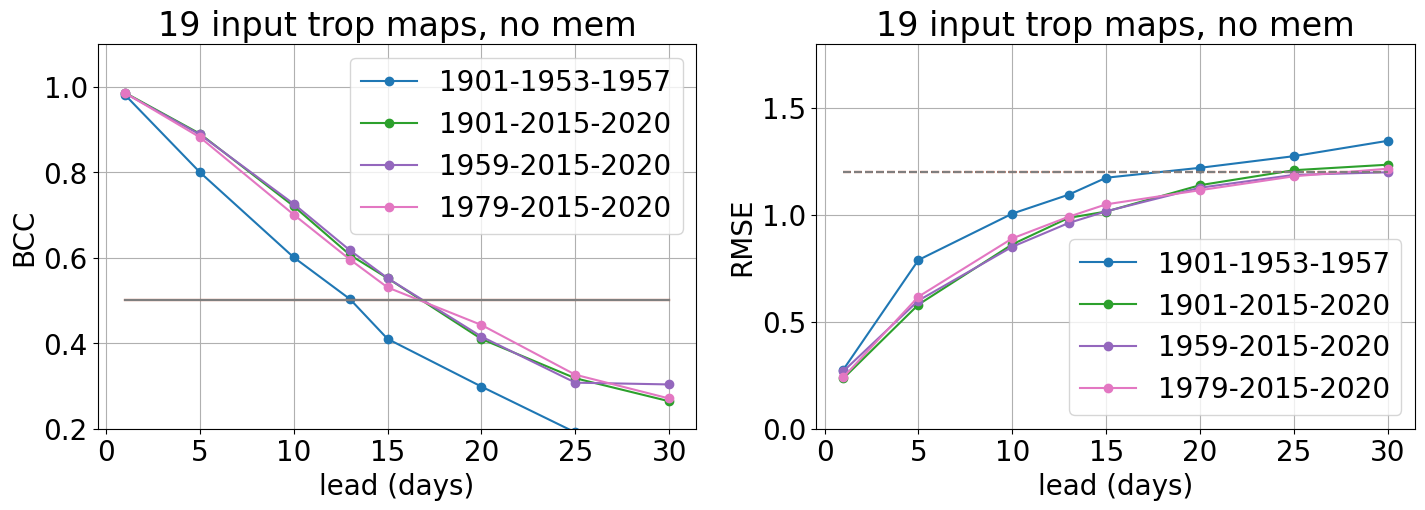

In [59]:
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(17,5))
gs = fig.add_gridspec(1, 2, hspace=0.05, wspace=0.2)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

for exp in range(len(yrsta)):
    testyrsta = yrvld[exp]
    testyrend = yrend[exp]
    ax[0].plot(lead, BCC_exp[exp], 'o-', label=str(yrsta[exp])+'-'+str(testyrsta)+'-'+str(testyrend))
    ax[0].plot(lead, 0.5 * np.ones(len(lead)))
    ax[0].legend()

    ax[1].plot(lead, RMSE_exp[exp], 'o-', label=str(yrsta[exp])+'-'+str(testyrsta)+'-'+str(testyrend))
    ax[1].legend()
    ax[1].plot(lead,1.2*np.ones(len(lead)),'--')

ax[1].set_title(str(varnum)+' input '+flg+' maps, no mem')
ax[1].set_xlabel('lead (days)')
ax[1].set_ylabel('RMSE')
ax[1].set_ylim([0,1.8])
ax[1].grid(visible=True)
ax[0].set_title(str(varnum)+' input '+flg+' maps, no mem')
ax[0].set_xlabel('lead (days)')
ax[0].set_ylabel('BCC')
ax[0].set_ylim([0.2,1.1])
ax[0].grid(visible=True)

In [29]:
# def get_phase(RMM1, RMM2):
#     if RMM1>=0 and RMM2>=0 and RMM1>=RMM2:
#         return 5
#     elif RMM1>=0 and RMM2>=0 and RMM1<=RMM2:
#         return 6
#     elif RMM1<=0 and RMM2>=0 and -RMM1<=RMM2:
#         return 7
#     elif RMM1<=0 and RMM2>=0 and -RMM1>=RMM2:
#         return 8 
#     elif RMM1<=0 and RMM2<=0 and RMM1<=RMM2:
#         return 1
#     elif RMM1<=0 and RMM2<=0 and RMM1>=RMM2:
#         return 2 
#     elif RMM1>=0 and RMM2<=0 and RMM1<=-RMM2:
#         return 3
#     elif RMM1>=0 and RMM2<=0 and RMM1>=-RMM2:
#         return 4

In [42]:
# # get initial phase
# iniRMM = xr.open_dataset(fnRMM)

# if nmem == 1:
#     a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
#     b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))
# elif nmem == 30:
#     a = iniRMM.sel(time=slice('2015-01-30','2017-01-28'))
#     b = iniRMM.sel(time=slice('2017-01-30','2020-01-29'))

# iniRMM = xr.concat((a,b), dim='time')
# del a 
# del b 
# RMM1 = iniRMM['RMM'][:,0]
# RMM2 = iniRMM['RMM'][:,1]
# Phase = np.zeros(len(RMM1))

# for i in np.arange(len(RMM1)):
#     Phase[i] = get_phase(RMM1[i],RMM2[i])

# # Phase

(0.2, 1.1)

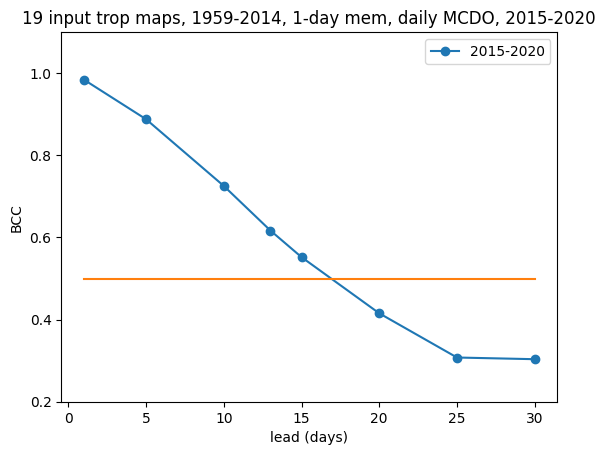

In [43]:
import matplotlib.pyplot as plt 

plt.plot(lead, BCC, 'o-', label=str(testyrsta)+'-'+str(testyrend))
plt.plot(lead, 0.5 * np.ones(len(lead)))
plt.legend()

plt.title(str(varnum)+' input '+flg+' maps, '+str(yrsta[exp])+'-'+str(yrvld[exp]-1)+', 1-day mem, daily MCDO, '+str(testyrsta)+'-'+str(testyrend))
plt.xlabel('lead (days)')
plt.ylabel('BCC')
plt.ylim([0.2,1.1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 1.8)

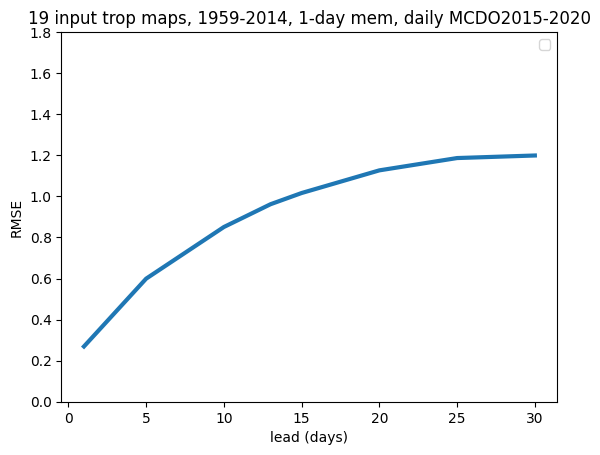

In [44]:
import matplotlib.pyplot as plt 
avRMSE = np.mean(RMSE,axis=1)
# averr = np.mean(err,axis=1)
# plt.errorbar(lead, avRMSE, yerr=averr/2.0)
plt.plot(lead, avRMSE, linewidth=3)
# plt.plot([1,3,5,10,15,20,25,30], 1.2 * np.ones(8))
plt.legend()
plt.title(str(varnum)+' input '+flg+' maps, '+str(yrsta[exp])+'-'+str(yrvld[exp]-1)+', 1-day mem, daily MCDO'+str(testyrsta)+'-'+str(testyrend))
plt.xlabel('lead (days)')
plt.ylabel('RMSE')
plt.ylim([0,1.8])
# plt.plot(lead,1*np.ones(len(lead)),'--')

NameError: name 'yrlen' is not defined

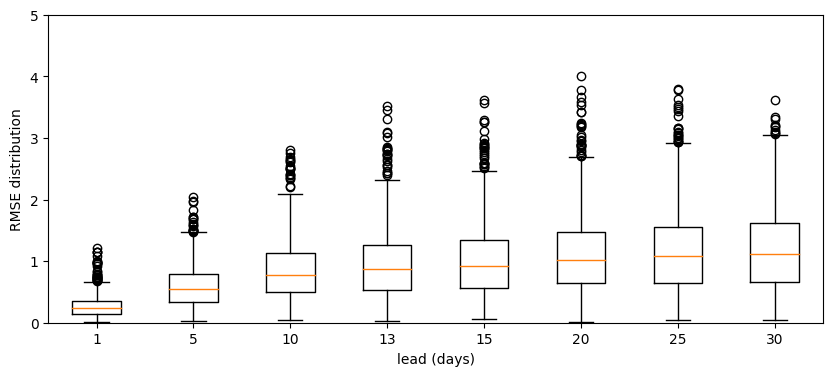

In [45]:
# ds[ilead]['time']
fig, ax = plt.subplots(figsize=(10,4))
ax.boxplot(RMSE)
ax.set_xticklabels(lead)
plt.xlabel('lead (days)')
plt.ylabel('RMSE distribution')
plt.ylim([0,5])
plt.title(str(varnum)+' input '+flg+' maps, '+str(yrlen)+' years, 1-day mem, daily MCDO, 2015-2019')
ax.plot(np.arange(len(lead)+2),1.2*np.ones(len(lead)+2),'--')

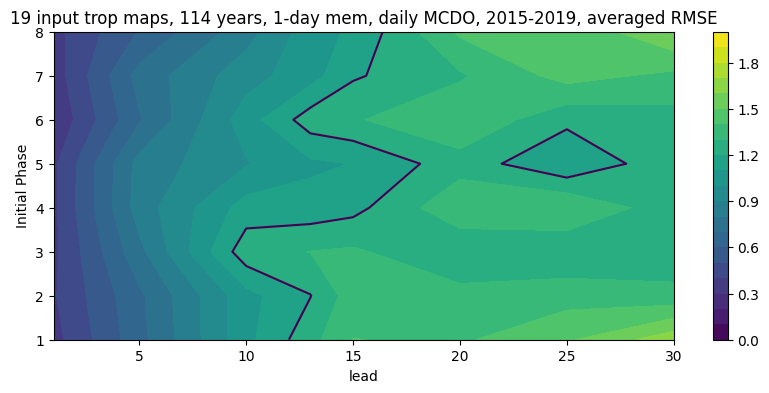

In [ ]:
# lead and phase plot
ds1 = ds.copy()
RMSE_pha = np.zeros((len(lead),8))  # RMSE associated with 8 phases
fig, ax = plt.subplots(figsize=(10,4))
for ilead, leadmjo in zip(np.arange(len(lead)), lead):
    RMSE_pha[ilead,:] = ds1[ilead].groupby(['Phase']).mean()['RMSE']

del ds1
h = ax.contourf(lead, np.arange(1,9), np.transpose(RMSE_pha), levels = np.linspace(0,2,21))
# ax.legend(ncol=len(lead))
ax.set_xlabel('lead')
ax.set_ylabel('Initial Phase')
ax.set_title(str(varnum)+' input '+flg+' maps, '+str(yrlen)+' years, 1-day mem, daily MCDO, 2015-2019, averaged RMSE')
plt.colorbar(h)
ax.contour(lead, np.arange(1,9), np.transpose(RMSE_pha),[1.2])

(0.0, 5.0)

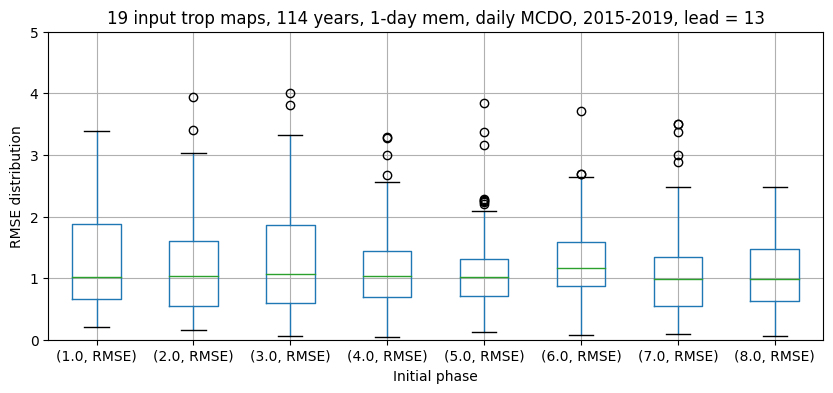

In [ ]:
# for lead = 15 how the error depends on initial phase?
fig, ax = plt.subplots(figsize=(10,4))
# ax.plot(ds1[ilead].count()['std'], 'o', label=leadmjo)
ds[3].groupby(['Phase']).boxplot(subplots=False, column='RMSE')
# ax.set_xticklabels(lead)
plt.xlabel('Initial phase')
plt.ylabel('RMSE distribution')
plt.title(str(varnum)+' input '+flg+' maps, '+str(yrlen)+' years, 1-day mem, daily MCDO, 2015-2019, lead = 13')
# ax.plot(np.arange(11),1.2*np.ones(11),'--')
plt.ylim([0,5])

(-100.0, 100.0)

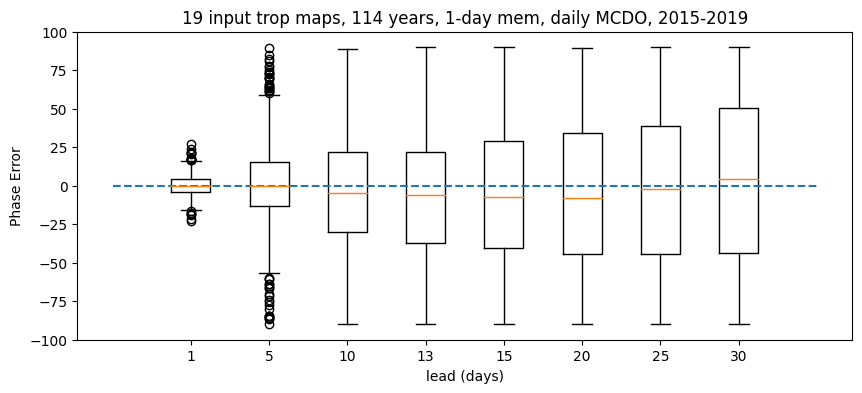

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
ax.boxplot(pha_err)
ax.set_xticklabels(lead)
plt.xlabel('lead (days)')
plt.ylabel('Phase Error')
plt.title(str(varnum)+' input '+flg+' maps, '+str(yrlen)+' years, 1-day mem, daily MCDO, 2015-2019')
ax.plot(np.arange(len(lead)+2),np.zeros(len(lead)+2),'--')
plt.ylim([-100,100])

Text(0.5, 1.0, '19 input trop maps, 114 years, 1-day mem, daily MCDO, 2015-2019')

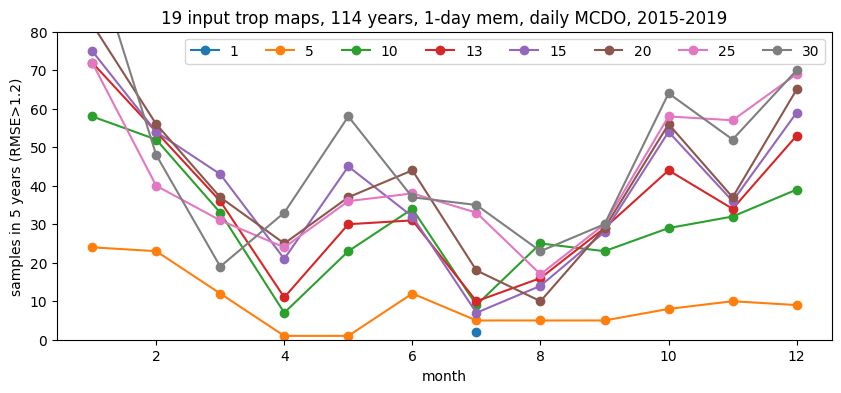

In [ ]:
ds1 = ds.copy()
fig, ax = plt.subplots(figsize=(10,4))
for ilead, leadmjo in zip(np.arange(0, len(lead)), lead):
    ds1[ilead] = ds[ilead].loc[ds[ilead]['RMSE']>=1.2]
    ax.plot(ds1[ilead].groupby(['month']).count()['std'], 'o-', label=leadmjo)

ax.legend(ncol=len(lead))
ax.set_xlabel('month')
ax.set_ylim([0,80])
ax.set_ylabel('samples in 5 years (RMSE>1.2)')
ax.set_title(str(varnum)+' input '+flg+' maps, '+str(yrlen)+' years, 1-day mem, daily MCDO, 2015-2019')

Text(0.5, 1.0, '19 input trop maps, 114 years, 1-day mem, daily MCDO, 2015-2019')

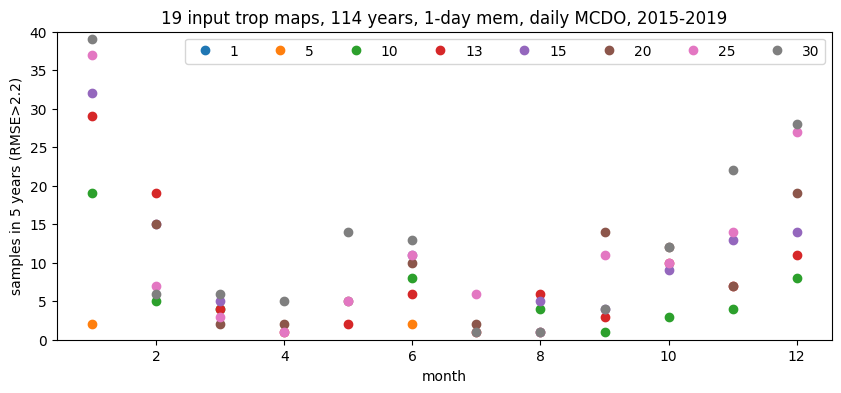

In [ ]:
del ds1 
ds1 = ds.copy()
fig, ax = plt.subplots(figsize=(10,4))
for ilead, leadmjo in zip(np.arange(0, len(lead)), lead):
    ds1[ilead] = ds[ilead].loc[ds[ilead]['RMSE']>=2.2]
    ax.plot(ds1[ilead].groupby(['month']).count()['std'], 'o', label=leadmjo)

ax.legend(ncol=len(lead))
ax.set_xlabel('month')
ax.set_ylabel('samples in 5 years (RMSE>2.2)')
ax.set_ylim([0,40])
ax.set_title(str(varnum)+' input '+flg+' maps, '+str(yrlen)+' years, 1-day mem, daily MCDO, 2015-2019')

Text(0.5, 1.0, '19 input trop maps, 114 years, 1-day mem, daily MCDO, 2015-2019')

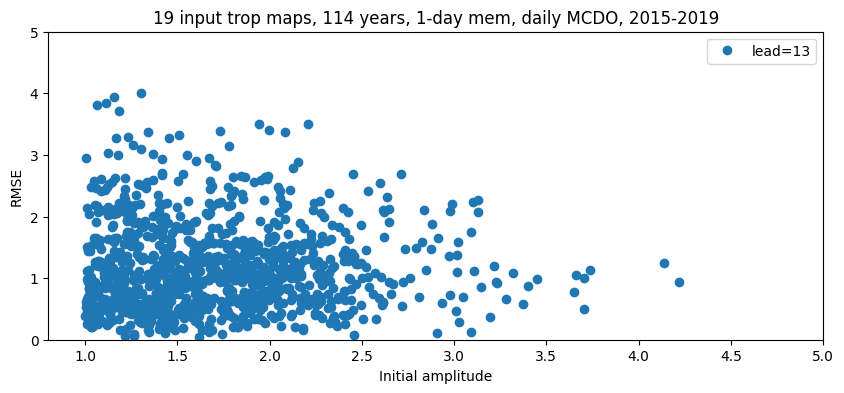

In [ ]:
del ds1 
ilead = 3
ds1 = ds.copy()
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(ds1[ilead]['IniAmp'].values, ds1[ilead]['RMSE'].values, 'o', label='lead='+str(lead[ilead]))

ax.legend(ncol=len(lead))
ax.set_xlabel('Initial amplitude')
ax.set_ylabel('RMSE')
ax.set_ylim([0,5])
ax.set_xlim([0.8,5])
ax.set_title(str(varnum)+' input '+flg+' maps, '+str(yrlen)+' years, 1-day mem, daily MCDO, 2015-2019')

Text(0.5, 1.0, 'lead=20')

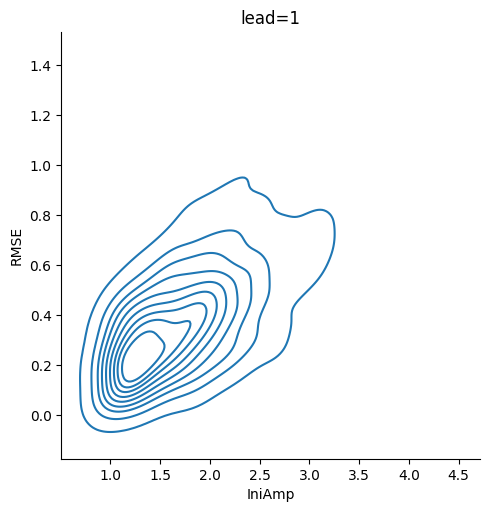

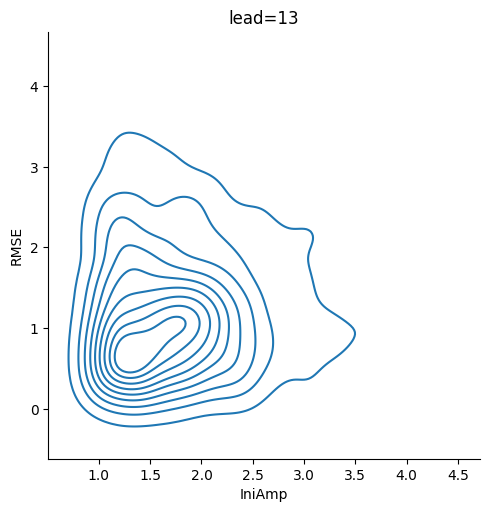

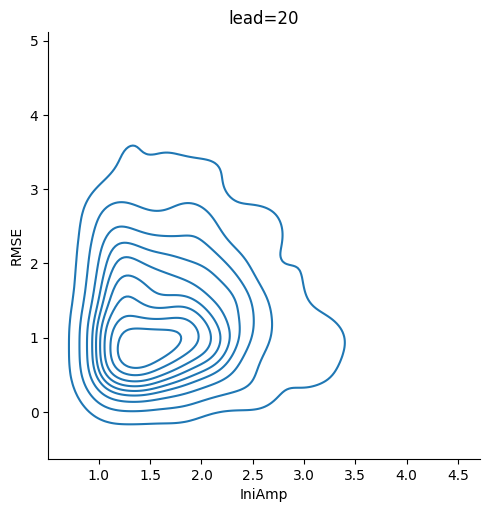

In [ ]:
import seaborn as sns

ilead = 0
ds1 = pd.concat((ds[ilead].IniAmp, ds[ilead].RMSE),axis=1)
sns.displot(ds1, x="IniAmp", y="RMSE", kind="kde")
plt.title('lead=' + str(lead[ilead]))

ilead = 3
ds1 = pd.concat((ds[ilead].IniAmp, ds[ilead].RMSE),axis=1)
sns.displot(ds1, x="IniAmp", y="RMSE", kind="kde")
plt.title('lead=' + str(lead[ilead]))


ilead = 5
ds1 = pd.concat((ds[ilead].IniAmp, ds[ilead].RMSE),axis=1)
sns.displot(ds1, x="IniAmp", y="RMSE", kind="kde")
plt.title('lead=' + str(lead[ilead]))

# plt.ylabel('Density')
# plt.ylim([0,1.0])
# plt.xlabel('RMSE')
# plt.xlim([-0.1,5])


Below is for one input map runs.

In [ ]:
# import numpy as np 
# import xarray as xr
# import pandas as pd 
# import os.path
# import matplotlib.pyplot as plt 

# # 1 input map
# # combine the prediction in 2015-2019
# nmem = 1  # use 30 time steps in each input map
# varn = ['u200','u500','u850','olr','tcwv','prep','sst','T200','T500','T850','v200','v500','v850','q200','q500','q850','Z200','Z500','Z850']

# BCC =[]
# RMSE =[]
# err = []
# avRMSE = []
# averr = []

# for ivarn, var in zip(np.arange(len(varn)), varn):
#     if nmem == 30:
#         dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/1maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output_dp0102_1dmem_'+varn[ivarn]+'/'
#     elif nmem == 1:
#         dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/1maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output_dp0102_1dmem_'+varn[ivarn]+'/'

#     lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead
#     BCC0  = []
#     RMSE0 = []
#     err0  = []

#     for ilead, leadmjo in zip(np.arange(len(lead)), lead): 
#         ds = []
#         # combine 2015-2019 prediction for the lead
#         dsp = []
#         dst = []
#         dspstd = []

#         for yn in np.arange(2015,2020):
#             fnp=dirn + 'predicted_disav_MCDO_UNET_'+varn[ivarn]+'trop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
#             fnt=dirn + 'truth_MCDO_UNET_'+varn[ivarn]+'trop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
#             fnpstd=dirn + 'predicted_disstd_MCDO_UNET_'+varn[ivarn]+'trop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'

#             df = pd.read_csv(fnp,index_col=None, header=None, names=['RMMp1','RMMp2'])
#             dsp.append(df)
#             del df 
#             df = pd.read_csv(fnt,index_col=None, header=None, names=['RMMt1','RMMt2'])
#             dst.append(df)
#             del df 
#             df = pd.read_csv(fnpstd,index_col=None, header=None, names=['std1','std2'])
#             dspstd.append(df)
#             del df 

#         dsp0 = pd.concat(dsp, axis=0, ignore_index=True)
#         dst0 = pd.concat(dst, axis=0, ignore_index=True)
#         dspstd0 = pd.concat(dspstd, axis=0, ignore_index=True)

#         ds0 = pd.concat((dsp0,dst0,dspstd0), axis=1)

#         ds.append(ds0)
#         del ds0
            
#         iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
        
#         if nmem == 1:
#             a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
#             b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))
#         elif nmem == 30:
#             a = iniRMM.sel(time=slice('2015-01-30','2017-01-28'))
#             b = iniRMM.sel(time=slice('2017-01-30','2020-01-29'))

#         iniRMM = xr.concat((a,b), dim='time')
#         del a 
#         del b 
#         RMM1 = iniRMM['RMM'][:,0]
#         RMM2 = iniRMM['RMM'][:,1]
#         IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)
#         ds[0]['IniAmp'] = IniAmp.values 

#         std1 = ds[0]['std1']
#         std2 = ds[0]['std2']
#         std = np.sqrt(std1*std1+std2*std2)
#         ds[0]['std'] = std.values

#         # finish combination
#         # evaluation starts 
#         ds = ds[0]
#         ds = ds.loc[ds['IniAmp']>=1]

#         r1p = np.asarray(ds['RMMp1'])
#         r2p = np.asarray(ds['RMMp2'])
#         r1t = np.asarray(ds['RMMt1'])
#         r2t = np.asarray(ds['RMMt2'])
#         std = np.asarray(ds['std'])

#         A = np.sum(r1p * r1t + r2p * r2t)
#         B = np.sqrt(np.sum(r1p * r1p + r2p * r2p))
#         C = np.sqrt(np.sum(r1t * r1t + r2t * r2t))
#         BCC0.append(A / B / C)

#         d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
#         RMSE0.append(np.sqrt(d))  # RMSE at each time step
#         err0.append(std)
#         del ds 

#     avRMSE.append(np.mean(RMSE0,axis=1))
#     averr.append(np.mean(err0,axis=1))
#     BCC.append(BCC0)
#     RMSE.append(RMSE0)
#     err.append(err0)


In [ ]:
# import matplotlib.pyplot as plt 

# plt.plot(lead, np.transpose(BCC[0:10]), 'o-', label=varn[0:10])
# plt.plot(lead, 0.5 * np.ones(len(lead)),'k')
# plt.legend()
# plt.title('1 input map, '+str(nmem)+'-day mem, daily MCDO')
# plt.xlabel('lead (days)')
# plt.ylabel('BCC')
# plt.ylim([0.1, 1.0])

In [ ]:
# import matplotlib.pyplot as plt 

# plt.plot(lead, np.transpose(BCC[10:]), 'o-', label=varn[10:])
# plt.plot(lead, 0.5 * np.ones(len(lead)),'k')
# plt.legend()
# plt.title('1 input map, '+str(nmem)+'-day mem, daily MCDO')
# plt.xlabel('lead (days)')
# plt.ylabel('BCC')
# plt.ylim([0.1, 1.0])

In [ ]:
# import matplotlib.pyplot as plt 
# num_plots = 19
# # colormap = plt.cm.Accent
# plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_ncar(np.linspace(0, 0.98, num_plots))))

# plt.plot(lead, np.transpose(BCC), 'o-', label=varn)
# plt.plot(lead, 0.5 * np.ones(len(lead)),'k')
# plt.legend()
# plt.title('1 input map, '+str(nmem)+'-day mem, daily MCDO')
# plt.xlabel('lead (days)')
# plt.ylabel('BCC')
# plt.ylim([0.1, 1.0])

In [ ]:
# import matplotlib.pyplot as plt 
# num_plots = 19
# # colormap = plt.cm.Accent
# plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_ncar(np.linspace(0, 0.98, num_plots))))

# plt.plot(lead, np.transpose(avRMSE), 'o-', label=varn)
# # plt.errorbar(lead, np.transpose(avRMSE), yerr=np.transpose(averr)/2.0, label=varn)
# # plt.plot([1,3,5,10,15,20,25,30], 1.2 * np.ones(8))
# # plt.legend()
# plt.title('1 input map, '+str(nmem)+'-day mem, daily MCDO')
# plt.xlabel('lead (days)')
# plt.ylabel('RMSE')

In [ ]:
# import matplotlib.pyplot as plt 
# plt.plot(lead, np.transpose(avRMSE[0:10]), 'o-', label=varn[0:10])
# # for i in np.arange(8):
# #     plt.errorbar(lead, np.transpose(avRMSE[i]), yerr=np.transpose(averr[i])/2.0, label=varn[i])
# # plt.plot([1,3,5,10,15,20,25,30], 1.2 * np.ones(8))
# plt.legend()
# plt.title('1 input map, '+str(nmem)+'-day mem, daily MCDO')
# plt.xlabel('lead (days)')
# plt.ylabel('RMSE')

In [ ]:
# plt.plot(lead, np.transpose(avRMSE[10:]), 'o-', label=varn[10:])
# # for i in np.arange(8):
# #     plt.errorbar(lead, np.transpose(avRMSE[i]), yerr=np.transpose(averr[i])/2.0, label=varn[i])
# # plt.plot([1,3,5,10,15,20,25,30], 1.2 * np.ones(8))
# plt.legend()
# plt.title('1 input map, '+str(nmem)+'-day mem, daily MCDO')
# plt.xlabel('lead (days)')
# plt.ylabel('RMSE')

In [ ]:
# import matplotlib.pyplot as plt 
# plt.plot(lead, np.transpose(averr), 'o-', label=varn)
# # plt.errorbar(lead, np.transpose(avRMSE), yerr=np.transpose(averr)/2.0, label=varn)
# # plt.plot([1,3,5,10,15,20,25,30], 1.2 * np.ones(8))
# plt.legend()
# plt.title('1 input map, '+str(nmem)+'-day mem, daily MCDO')
# plt.xlabel('lead (days)')
# plt.ylabel('RMSE uncertainty')

In [ ]:
# # combine the prediction in 2015-2019
# nmem = 1  # use 30 time steps in each input map

# dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output/'
# varnum = 19

# # if nmem == 30:
# #     dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/7maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output_dp0203_30mem/'
# # elif nmem == 1:
# #     dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/7maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output_dp0102_ep50_1mem/'

# lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead
# BCC  = []
# RMSE = []
# err  = []

# for ilead, leadmjo in zip(np.arange(len(lead)), lead): 
#     ds = []
#     # combine 2015-2019 prediction for the lead
#     dsp = []
#     dst = []
#     dspstd = []

#     for yn in np.arange(2015,2020):
#         fnp=dirn + 'predicted_MCDO_UNET_'+str(varnum)+'mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
#         fnt=dirn + 'truth_MCDO_UNET_'+str(varnum)+'mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
#         fnpstd=dirn + 'predicted_disstd_MCDO_UNET_'+str(varnum)+'mapstrop_RMMERA5_36yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'

#         df = pd.read_csv(fnp,index_col=None, header=None, names=['RMMp1','RMMp2'])
#         dsp.append(df)
#         del df 
#         df = pd.read_csv(fnt,index_col=None, header=None, names=['RMMt1','RMMt2'])
#         dst.append(df)
#         del df 
#         df = pd.read_csv(fnpstd,index_col=None, header=None, names=['std1','std2'])
#         dspstd.append(df)
#         del df 

#     dsp0 = pd.concat(dsp, axis=0, ignore_index=True)
#     dst0 = pd.concat(dst, axis=0, ignore_index=True)
#     dspstd0 = pd.concat(dspstd, axis=0, ignore_index=True)

#     ds0 = pd.concat((dsp0,dst0,dspstd0), axis=1)

#     ds.append(ds0)
#     del ds0
        
#     iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
    
#     if nmem == 1:
#         a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
#         b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))
#     elif nmem == 30:
#         a = iniRMM.sel(time=slice('2015-01-30','2017-01-28'))
#         b = iniRMM.sel(time=slice('2017-01-30','2020-01-29'))

#     iniRMM = xr.concat((a,b), dim='time')
#     del a 
#     del b 
#     RMM1 = iniRMM['RMM'][:,0]
#     RMM2 = iniRMM['RMM'][:,1]
#     IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)
#     ds[0]['IniAmp'] = IniAmp.values 

#     std1 = ds[0]['std1']
#     std2 = ds[0]['std2']
#     std = np.sqrt(std1*std1+std2*std2)
#     ds[0]['std'] = std.values

#     # finish combination
#     # evaluation starts 
#     ds = ds[0]
#     ds = ds.loc[ds['IniAmp']>=1]

#     r1p = np.asarray(ds['RMMp1'])
#     r2p = np.asarray(ds['RMMp2'])
#     r1t = np.asarray(ds['RMMt1'])
#     r2t = np.asarray(ds['RMMt2'])
#     std = np.asarray(ds['std'])

#     A = np.sum(r1p * r1t + r2p * r2t)
#     B = np.sqrt(np.sum(r1p * r1p + r2p * r2p))
#     C = np.sqrt(np.sum(r1t * r1t + r2t * r2t))
#     BCC.append(A / B / C)

#     d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
#     RMSE.append(np.sqrt(d))  # RMSE at each time step
#     err.append(std)
#     del ds 

# np.shape(RMSE) 


In [ ]:
# import matplotlib.pyplot as plt 

# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,0], yerr=err[:,0], label='2015')
# # plt.plot([1,3,5,10,15,20,25,30], RMSE, 'o-', label=['2015','2016','2017','2018','2019'])
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,1], yerr=err[:,1], label='2016')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,2], yerr=err[:,2], label='2017')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,3], yerr=err[:,3], label='2018')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,4], yerr=err[:,4], label='2019')
# # plt.plot([1,3,5,10,15,20,25,30], 1.2 * np.ones(8))
# plt.legend()
# plt.title('7 tropical maps, 1-day mem, daily MCDO')
# plt.xlabel('lead (days)')
# plt.ylabel('RMSE')

In [ ]:
# import matplotlib.pyplot as plt 

# # plt.errorbar([1,3,5,10,15,20,25,30], BCC[:,3], yerr=err[:,3])
# plt.plot([1,3,5,10,15,20,25,30], BCC, 'o-', label=['2015','2016','2017','2018','2019'])
# # plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,1], yerr=err[:,1], label='2016')
# # plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,2], yerr=err[:,2], label='2017')
# # plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,3], yerr=err[:,3], label='2018')
# # plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,4], yerr=err[:,4], label='2019')
# plt.plot([1,3,5,10,15,20,25,30], 0.5 * np.ones(8))
# plt.legend()
# plt.title('7 tropical maps, 1-day mem, daily MCDO')
# plt.xlabel('lead (days)')
# plt.ylabel('BCC')

In [ ]:
# dirn = '~/ERA5/script/Stability-Explanability/7maps_36yrtraining_RMMERA5_filtered_trop/output/'
# iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
# a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
# b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))

# BCC = []
# yn = 2015
# iniRMM = xr.concat((a,b), dim='time')

# del a 

# for lead in np.arange(1,31):

#     fnp = dirn + 'predicted_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
#     fnt = dirn + 'truth_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'

#     dsp = pd.read_csv(fnp, header=None, names=['RMMp1','RMMp2'])
#     dst = pd.read_csv(fnt, header=None, names=['RMMt1','RMMt2'])

#     a = iniRMM.sel(time=slice(str(yn)+'-01-01',str(yn)+'-12-31'))
#     RMM1 = a['RMM'][:,0]
#     RMM2 = a['RMM'][:,1]
#     IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)

#     ds = pd.concat((dsp,dst), axis=1)
#     ds['IniAmp'] = IniAmp.values 

#     ds = ds.loc[ds['IniAmp']>=1]

#     pc1p = np.asarray(ds['RMMp1'])
#     pc2p = np.asarray(ds['RMMp2'])
#     pc1t = np.asarray(ds['RMMt1'])
#     pc2t = np.asarray(ds['RMMt2'])

#     d = (pc1t-pc1p)*(pc1t-pc1p)+(pc2t-pc2p)*(pc2t-pc2p)
#     tmp = np.sqrt(d)
#     # A = r1p * r1t + r2p * r2t
#     # B = np.sqrt(r1p * r1p + r2p * r2p)
#     # C = np.sqrt(r1t * r1t + r2t * r2t)
#     # tmp = A / B / C 
#     # BCC.append(tmp)

#     plt.boxplot(d)
#     # plt.scatter(lead*np.ones(tmp.shape), tmp)  # , label=['2015','2016','2017','2018','2019'])
#     del tmp 
#     # plt.plot(np.arange(1,31), 0.5 * np.ones(30))
#     # plt.legend()
#     # plt.title('7 tropical maps, 1-day mem')
#     # plt.xlabel('lead (days)')
#     # plt.ylabel('BCC')

In [ ]:
# import numpy as np 
# import xarray as xr
# import pandas as pd 
# import os.path
# import matplotlib.pyplot as plt 

# dirn = '~/ERA5/script/Stability-Explanability/7maps_36yrtraining_RMMERA5_filtered_trop/output/'
# iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
# a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
# b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))

# BCC = []
# RMSE = []

# iniRMM = xr.concat((a,b), dim='time')

# del a 

# for yn in np.arange(2015,2016):

#     for lead in np.arange(1,31):

#         fnp = dirn + 'predicted_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
#         fnt = dirn + 'truth_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'

#         dsp = pd.read_csv(fnp, header=None, names=['RMMp1','RMMp2'])
#         dst = pd.read_csv(fnt, header=None, names=['RMMt1','RMMt2'])

#         a = iniRMM.sel(time=slice(str(yn)+'-01-01',str(yn)+'-12-31'))
#         RMM1 = a['RMM'][:,0]
#         RMM2 = a['RMM'][:,1]
#         IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)

#         ds = pd.concat((dsp,dst), axis=1)
#         ds['IniAmp'] = IniAmp.values 
#         ds['time'] = a['time']

#         ds = ds.iloc[0:,:]

#         ds = ds.loc[ds['IniAmp']>=1]

#         pc1p = np.asarray(ds['RMMp1'])
#         pc2p = np.asarray(ds['RMMp2'])
#         pc1t = np.asarray(ds['RMMt1'])
#         pc2t = np.asarray(ds['RMMt2'])

#         d = (pc1t-pc1p)*(pc1t-pc1p)+(pc2t-pc2p)*(pc2t-pc2p)
#         tmp = np.sqrt(d)
#         RMSE.append(tmp)

#         del tmp 
        
#         r1p = np.asarray(ds['RMMp1'])
#         r2p = np.asarray(ds['RMMp2'])
#         r1t = np.asarray(ds['RMMt1'])
#         r2t = np.asarray(ds['RMMt2'])

#         A = r1p * r1t + r2p * r2t
#         B = np.sqrt(r1p * r1p + r2p * r2p)
#         C = np.sqrt(r1t * r1t + r2t * r2t)
#         tmp = A / B / C 
#         BCC.append(tmp)

#         # plt.scatter(lead*np.ones(tmp.shape), tmp)  # , label=['2015','2016','2017','2018','2019'])
#         del tmp 
#         # plt.plot(np.arange(1,31), 0.5 * np.ones(30))
#         # plt.legend()
#         # plt.title('7 tropical maps, 1-day mem')
#         # plt.xlabel('lead (days)')
#         # plt.ylabel('BCC')



In [ ]:
# fig = plt.figure(figsize=(10,4))
# plt.boxplot(RMSE)
# plt.xlabel('lead (days)')
# plt.ylabel('RMSE distribution')
# plt.title(str(yn))


In [ ]:
# fig = plt.figure(figsize=(10,4))
# plt.boxplot(BCC)
# plt.xlabel('lead (days)')
# plt.ylabel('Normalized correlation distribution')
# plt.title(str(yn))